# Readme
This notebook runs with environment VIP. Written by Gilles Otten, partially based on the VIP_HCI tutorial by Valentin Christiaens and Carlos Gomez Gonzalez.

# Importing modules

In [17]:
import numpy as np
#import heeps
from astropy.io import fits
import scipy.interpolate
import matplotlib.pyplot as plt
import scipy.signal
import astropy.modeling
from vip_hci.preproc import frame_rotate
from vip_hci.preproc import cube_derotate

from heeps.util.paralang import paralang
from heeps.util.psf_template import psf_template
import vip_hci
import multiprocessing as mpro
from heeps.config import read_config,update_config

conf = read_config(verbose=False,band="N2",nframes=100,mode="CVC",call_ScopeSim=False,dit=0.011)
conf = update_config(saveconf=True, verbose=True, **conf)
pscale=conf['pscale'] # pixel scale in mas
ndet=conf['ndet'] # number of pixels in generated PSF
nframes=conf['nframes'] # number of frames to generate PSFs for
duration=conf['duration'] # total duration of imaging sequence (for field rotation)
lat=conf['lat'] # observatory latitude [degrees]
dec=conf['dec'] # target declination [degrees]

Simulation config: band=N2, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, diam_norm=1.0838, beam_ratio=0.1072
   npupil=119, pscale=6.7900 mas, lam=1.1330E-05 m
   hfov=1.1 arcsec (-> ndet=325, 17.42 lam/D)



# Load source (to compare against)

In [18]:
source0=fits.getdata("source_cube.fits")

pa = paralang(nframes//2, dec, lat, duration) # number of frames, declination of target, latitude of observatory, total sequence time in seconds.
pa = (pa + 360)%360

# Load ScopeSim output cube

In [19]:
num=ndet//2+1
cube_new=fits.getdata("source_cube_processed.fits")[:,(1024-num):(1024+num+1),(1024-num):(1024+num+1)]
cube_new_ref=fits.getdata("source_cube_processed_ref.fits")[:,(1024-num):(1024+num+1),(1024-num):(1024+num+1)]
cube_new_off=fits.getdata("source_cube_processed_off.fits")[:,(1024-num):(1024+num+1),(1024-num):(1024+num+1)]
cube_new_bkg=fits.getdata("source_cube_processed_bkg.fits")[:,(1024-num):(1024+num+1),(1024-num):(1024+num+1)]
bkg=np.median(cube_new_bkg,0)
cube_new=cube_new-bkg
cube_new_ref=cube_new_ref-bkg
cube_new_off=cube_new_off-bkg

# Applying angular differential imaging (ADI) and reference star differential imaging (RDI)
As the PSF structures are relatively static and the field rotates on the detector we can use this diversity to subtract the PSF structures and retain structures related to the on-sky source. With ADI the science images themselves are used to build the reference PSF. With RDI separate reference star dataset(s) are used. This RDI reference star should ideally be a point source. Use of the ADI technique can lead to self-subtraction, where real source features might end up in the reference PSF, especially with extended features. Both the RDI and ADI techniques also suffer from oversubtraction where real structures might be partially subtracted away by the reference PSF by similarity. Through injection and retrieval of artificial point sources, as well as forward modelling these dataprocessing artefacts can be dealt with.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-11-28 17:26:48
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted


/home/gotten/anaconda3/envs/vip/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1449) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Done derotating and combining
Running time:  0:00:31.481554
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-11-28 17:27:19
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted


/home/gotten/anaconda3/envs/vip/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1449) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Done derotating and combining
Running time:  0:00:31.298149
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


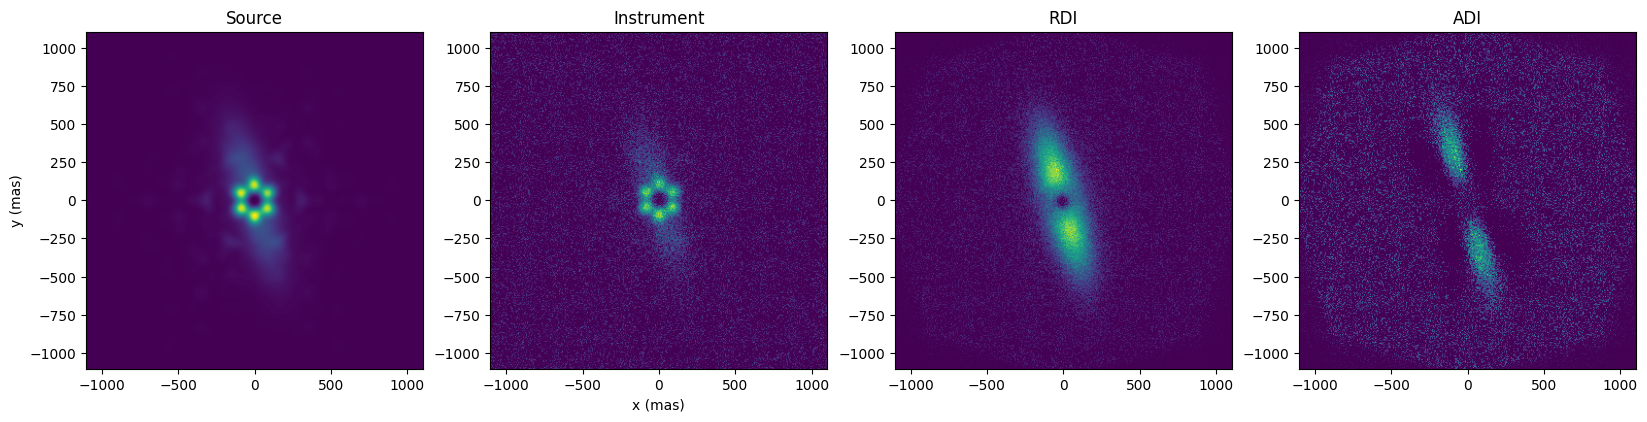

In [20]:
#plt.gray()
fig,ax=plt.subplots(nrows=1,ncols=4,figsize=(20,10))
ax[0].imshow(source0[nframes//4,:,:],origin="lower",extent=[-ndet*pscale/2,ndet*pscale/2,-ndet*pscale/2,ndet*pscale/2],vmin=0)
ax[0].set_title("Source")
ax[0].set_ylabel("y (mas)")
ax[1].imshow(cube_new[24,:,:],origin="lower",extent=[-ndet*pscale/2,ndet*pscale/2,-ndet*pscale/2,ndet*pscale/2],vmin=0)
_, fwhm, _ = psf_template(np.median(cube_new_off[:,:,:],0)) # determine FWHM from off-axis PSF.
ax[1].set_title("Instrument")
algo = vip_hci.psfsub.medsub.median_sub

#RDI, using a second cube of PSFs as reference.
frame = algo(cube_new, pa, nproc=2, full_output=True, verbose=True,fwhm=fwhm,cube_ref=cube_new_ref)
ax[2].imshow(frame[2],origin='lower',extent=[-ndet*pscale/2,ndet*pscale/2,-ndet*pscale/2,ndet*pscale/2],vmin=0)
ax[2].set_title("RDI")
#plt.show()

#simple ADI, works poorly with extended features.
frame = algo(cube_new, pa, nproc=2, full_output=True, verbose=True,fwhm=fwhm)
ax[3].imshow(frame[2],origin='lower',extent=[-ndet*pscale/2,ndet*pscale/2,-ndet*pscale/2,ndet*pscale/2],vmin=0)
ax[3].set_title("ADI")
ax[1].set_xlabel("x (mas)")
plt.show()